<h1>Prediction of House price based on the area</h1>
<h2>Using Scipy</h2>

In [22]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as pp
import seaborn as sns
%matplotlib inline

In [23]:
house_prices = pd.read_csv('house_prices.csv', header=None, names = ['area', 'noOfBedRooms', 'price'] )
house_prices.head()

,area,noOfBedRooms,price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


<h4>Analysis</h4>

In [24]:
house_prices = house_prices[['area', 'price']]
house_prices.head()

,area,price
0,2104,399900
1,1600,329900
2,2400,369000
3,1416,232000
4,3000,539900


In [25]:
house_prices.describe()

,area,price
count,47.000000,47.000000
mean,2000.680851,340412.659574
std,794.702354,125039.899586
min,852.000000,169900.000000
25%,1432.000000,249900.000000
50%,1888.000000,299900.000000
75%,2269.000000,384450.000000
max,4478.000000,699900.000000


In [26]:
house_prices.shape

(47, 2)

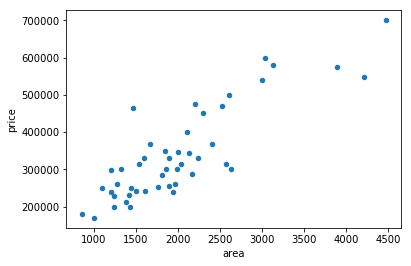

In [27]:
# Original Data plot
house_prices.plot.scatter(x='area', y='price')

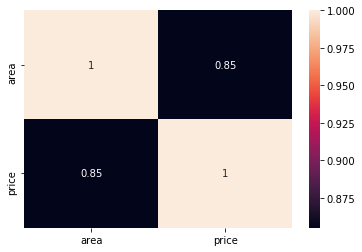

In [28]:
sns.heatmap(house_prices.corr(), annot=True) # we can see very high correlation

<h4>Pre-Process</h4>
<h5>Mean Normalisation</h5>

In [29]:
house_prices_norm = house_prices.copy()
for col in house_prices_norm.columns:
    mean = house_prices[col].mean()
    house_prices_norm[col] = house_prices[col].apply(lambda x : x - mean )

In [30]:
house_prices_norm.head()

,area,price
0,103.319149,59487.340426
1,-400.680851,-10512.659574
2,399.319149,28587.340426
3,-584.680851,-108412.659574
4,999.319149,199487.340426


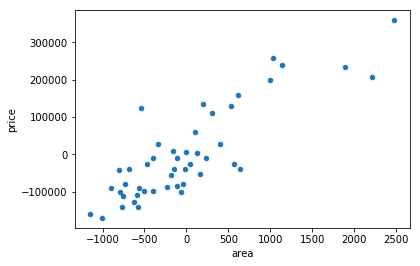

In [31]:
# Note: Plot is unchanged after mean normalisation although the axis scale has changed
house_prices_norm.plot.scatter(x='area', y ='price')

<h5>Feature scaling</h5>

In [32]:

for col in house_prices_norm.columns:
    min_val = house_prices_norm[col].min()
    std_dev = house_prices_norm[col].std()
    house_prices_norm[col] = house_prices_norm[col].apply(lambda x : (x - min_val)/ std_dev)

house_prices_norm.head()

,area,price
0,1.575433,1.839413
1,0.941233,1.279592
2,1.947899,1.592292
3,0.709700,0.496641
4,2.702899,2.959055


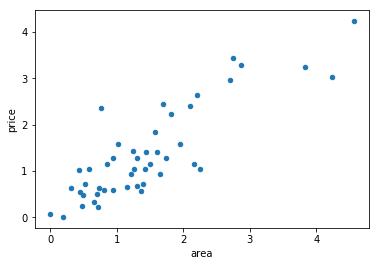

In [33]:
# Note the plot is similar but the axes are now of approximately same ranges
house_prices_norm.plot.scatter(x='area', y = 'price')

<b>The above steps are not always required but help to increase the performance of the training algorithm</B>
<br/>
<h5> Train and Test Split </h5>

In [34]:
noOfTrainExamples = house_prices_norm.shape[0] * 0.6
train_set = house_prices_norm.loc[:noOfTrainExamples]
test_set = house_prices_norm.loc[noOfTrainExamples:]

In [35]:
train_set.shape

(29, 2)

In [36]:
test_set.shape

(18, 2)

<h3> Build and Predict using Scipy linregress function </h3>
<br/>
<b>this function takes care of initial guess and finding theta0, theta1 but
can be only used for linear regression. (single or multivariate) </b>

In [37]:
slope, intercept, r_value,p_value, std_err = sp.stats.linregress(train_set['area'], train_set['price'])

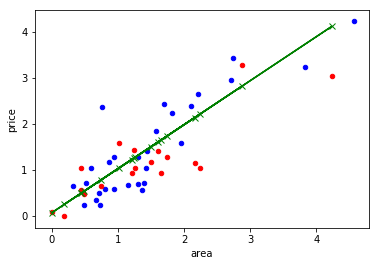

In [38]:
price_pred = slope * test_set['area'] + intercept

# plot the train data
fig, ax = pp.subplots()
train_set.plot.scatter(x='area', y = 'price', color = 'b', ax =ax)

# plot the test data
test_set.plot.scatter(x = 'area', y = 'price', color = 'r', ax =ax)
# plot the prediction
ax.plot(test_set['area'], price_pred, marker='x', c ='g')
pp.show()

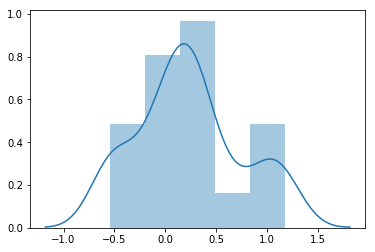

In [39]:
# Other indicators of good fit
# if the histogram indicates a normal (gaussian) distribution
sns.distplot(price_pred - test_set['price'])

<h4> Linear Regression using Numpy <h4>
<i>This method uses least squares method of Numpy
which takes in the matrix that represnts the M datapoints(rows) and 
N features (columns) and the actual values vector (each row represents 
actual values for each datapoint in the training set) </i>

In [40]:
area = house_prices_norm['area']
dummy = pd.Series(np.ones(len(area)), dtype=np.int32)
X_train = pd.concat([area, dummy], axis=1)
X_train.head()

,area,0
0,1.575433,1
1,0.941233,1
2,1.947899,1
3,0.709700,1
4,2.702899,1


In [41]:
Y_train = house_prices_norm['price']
slope, intercept = np.linalg.lstsq(X_train, Y_train)[0]
print(slope, intercept)

0.854987592878 0.127847492195


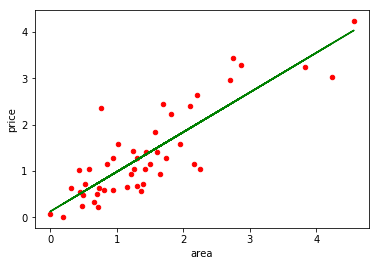

In [42]:
Y_pred = slope * house_prices_norm['area'] + intercept
# plot the entire dataset
fig, ax = pp.subplots()
house_prices_norm.plot.scatter(x='area', y = 'price', color = 'r', ax =ax)

# plot the prediction regression line
ax.plot(X_train['area'], Y_pred, c ='g')
pp.show()

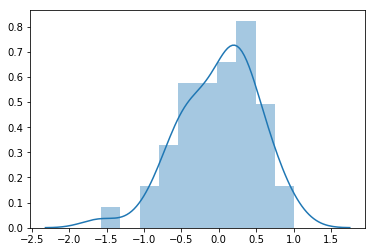

In [43]:
sns.distplot(Y_pred - Y_train, bins = 10)

<b> Using Numpy Polyfit </b>
<br>
<i>This method can be used to fit higher order polynomials as well.</i>

In [45]:
x = house_prices_norm['area']
y = house_prices_norm['price']
coeff1 = np.polyfit(x,y, 1) #1 indicates linear equation (order =1)
coeff1

array([ 0.85498759,  0.12784749])

In [46]:
ys = (coeff1[0] * x) + coeff1[1]
ys.shape

(47,)

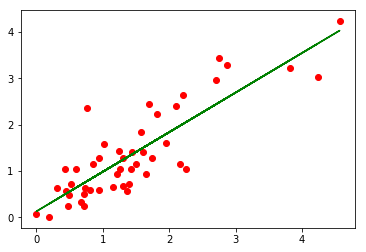

In [48]:
fig,axes = pp.subplots()
axes.scatter(x, y, c='r')
axes.plot(x, ys, 'g')



<h3>Using Scipy optimize </h3>
<i>
Linear regression by defining cost function and using scipy minimize
this can be used to minimize any function (we can calculate cost function
for any equation and then pass it to the miminize)
</i>

In [54]:
def cost_func(theta, x, y_actual):
    # calculate the prediction based in coefficients
    y_pred = x.dot(theta)
    # calculate mean square error
    mse = ((y_actual - y_pred) ** 2).mean()
    return mse

# intial value of coefficients
initial_coeff = np.ones(2)

x = house_prices_norm['area']
x = np.column_stack((np.ones(len(x)), x))
y_act = house_prices_norm['price']
print(x.shape)
res = sp.optimize.minimize(cost_func, initial_coeff, args= (x, y_act))
res



(47, 2)


      fun: 0.26327289227926814
 hess_inv: array([[ 1.56207925, -0.73595055],
       [-0.73595055,  0.50970809]])
      jac: array([ -7.45058060e-09,   0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 8
     njev: 9
   status: 0
  success: True
        x: array([ 0.12784749,  0.85498759])

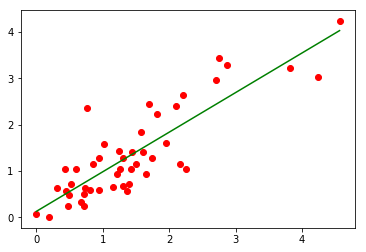

In [59]:
coeff = res.x

xs = np.linspace(x.min(), x.max(), 10)
ys = np.column_stack( (np.ones(len(xs)), xs)).dot(coeff) # ys = prediction for arbitrary values of xs

fig, axes = pp.subplots()
axes.scatter(x[:,1],y_act, marker='o', color='r')
axes.plot(xs,ys, 'g')